In [135]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import os

from sklearn.linear_model import LinearRegression
from geopy.distance import distance

In [111]:
DATA_DIR = "../datasets_full"
LONDON_BOROUGH_SHAPES = "./statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"

In [112]:
earnings = pd.read_csv(os.path.join(DATA_DIR, 'London', 'london_earnings_by_borough.csv'))

In [113]:
earnings.drop('confidence', axis=1, inplace=True)
earnings.dropna(inplace=True)

In [114]:
earnings.identity.value_counts()

Female       1665
Full-time    1663
Male         1651
Part-time     824
Part-Time     804
Name: identity, dtype: int64

In [115]:
earnings.head()

,year,area_code,area,identity,pay_type,pay
7,2009,00AA,City of London,Female,Hourly,17.56
10,2012,00AA,City of London,Female,Hourly,23.91
12,2014,00AA,City of London,Female,Hourly,16.74
13,2015,00AA,City of London,Female,Hourly,16.17
15,2017,00AA,City of London,Female,Hourly,22.15


In [116]:
# Assuming 40 hour work-week

def weekly_to_hourly(series):
    if series.pay_type == 'Weekly':
        series.pay_type = 'Hourly'
        series.pay /= 40
    
    return series
        
earnings = earnings.apply(weekly_to_hourly, axis=1)

In [117]:
earnings_per_area = earnings.pivot_table(index='area', columns='year', values='pay')

In [118]:
earnings_per_area.head()

year,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
area,,,,,,,,,,,,,,,,,,
Barking and Dagenham,8.954375,8.470313,8.492500,8.809062,9.585312,9.871563,10.236875,10.979375,10.294375,10.433437,10.687188,10.517812,10.349375,10.531875,10.810625,10.912188,11.485313,11.884687
Barnet,10.041562,10.916875,11.011250,11.050000,11.298125,11.408438,12.161875,12.707500,12.912813,12.798125,12.681250,12.894688,12.601250,12.634375,12.630937,13.725000,13.558125,13.881875
Bexley,9.354375,10.132187,10.030625,10.835313,10.538125,10.851250,11.575625,11.463125,11.670000,11.919063,12.077188,12.059062,12.119375,12.158437,12.959062,12.926250,13.156875,13.654063
Brent,8.565000,8.312812,9.140937,9.340000,9.435000,9.683125,10.147812,10.224063,10.060313,9.795625,10.601875,10.579688,10.767187,10.861562,10.999688,11.229062,11.638438,12.585000
Bromley,10.658438,11.250000,11.046250,11.566562,12.118125,12.681250,12.933125,13.458438,13.172500,13.304688,14.011250,14.130000,14.310938,14.125000,14.546250,15.092812,15.667500,15.997813


In [119]:
earnings_per_area.interpolate(inplace=True)

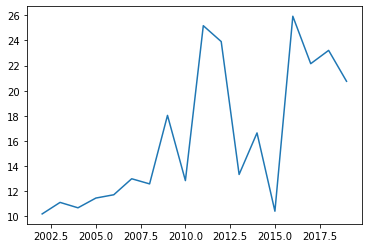

In [236]:
plt.plot(earnings_per_area.loc['City of London'])

Find difference in slopes before and after olympics
===================================================

In [120]:
before_olympics = earnings_per_area.loc[:, :2012]
after_olympics = earnings_per_area.loc[:, 2012:]

In [121]:
def get_slope(series):
    regressor = LinearRegression()
    
    indices = series.index.to_numpy().reshape(-1, 1)
    regressor.fit(indices, series)
    
    return regressor.coef_[0]

In [122]:
before_slopes = before_olympics.apply(get_slope, axis=1)
after_slopes = after_olympics.apply(get_slope, axis=1)

before_slopes = before_slopes.rename('before')
after_slopes = after_slopes.rename('after')

In [123]:
slopes = pd.concat([before_slopes, after_slopes], axis=1)

slopes['diff'] = (slopes['after'] - slopes['before']) / earnings_per_area.mean(axis=1)

In [132]:
slopes.head()

,before,after,diff
area,,,
Barking and Dagenham,0.244676,0.180800,-0.006272
Barnet,0.278244,0.179635,-0.008035
Bexley,0.254298,0.235100,-0.001650
Brent,0.194134,0.246421,0.005116
Bromley,0.326912,0.290004,-0.002767


Load london borough shape data
==============================

In [124]:
map_df = gpd.read_file(LONDON_BOROUGH_SHAPES)
map_df = map_df.to_crs('epsg:3857')

In [125]:
map_df.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((-36811.020 6679699.611, -36801.601 6..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((-7126.807 6677851.759, -7132.828 667..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((1350.415 6674461.413, 1331.568 66744..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((-27224.557 6708199.030, -27237.660 6..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((-45845.001 6716316.317, -45850.623 6..."


In [126]:
locations = pd.DataFrame({
    'Name': ['Olympic Park'],
    'Latitude': [51.54615],
    'Longitude': [-0.01269]
})

In [127]:
geo_locs = gpd.GeoDataFrame(locations, geometry=gpd.points_from_xy(locations.Longitude, locations.Latitude), crs="EPSG:4326")

In [128]:
geo_locs = geo_locs.to_crs('epsg:3857')

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until


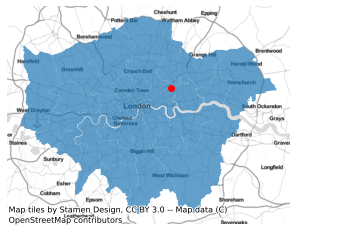

In [129]:
ax = map_df.plot(alpha=0.7)
geo_locs.plot(ax=ax, color='red', label="test", legend="bottomright")
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

Plot merged data
================

In [160]:
merged = map_df.set_index('NAME').join(slopes)

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  after removing the cwd from sys.path.


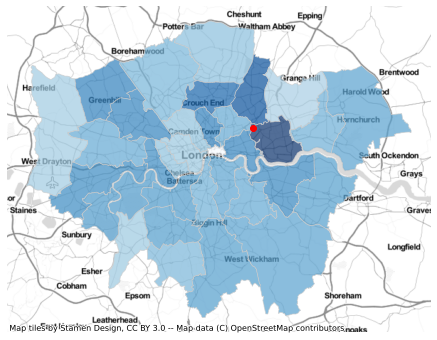

In [243]:
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column='diff', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7)
geo_locs.plot(ax=ax, color='red', label="test", legend=True)
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

In [231]:
merged['before'] = merged['before'] / earnings_per_area.mean(axis=1)

In [241]:
merged['before']['City of London'] = 0

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [234]:
merged['before']

NAME
Kingston upon Thames      0.030534
Croydon                   0.024098
Bromley                   0.024511
Hounslow                  0.018825
Ealing                    0.017671
Havering                  0.022270
Hillingdon                0.024996
Harrow                    0.024962
Brent                     0.018995
Barnet                    0.022671
Lambeth                   0.030351
Southwark                 0.030605
Lewisham                  0.019682
Greenwich                 0.022301
Bexley                    0.021851
Enfield                   0.023062
Waltham Forest            0.016734
Redbridge                 0.026768
Sutton                    0.024796
Richmond upon Thames      0.016304
Merton                    0.017550
Wandsworth                0.025726
Hammersmith and Fulham    0.021980
Kensington and Chelsea    0.023701
Westminster               0.032026
Camden                    0.023930
Tower Hamlets             0.025652
Islington                 0.022142
Hackney        

In [145]:
dists = pd.read_csv('region_distances.csv').set_index('NAME')

In [146]:
mdists = map_df.set_index('NAME').join(dists)

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  after removing the cwd from sys.path.


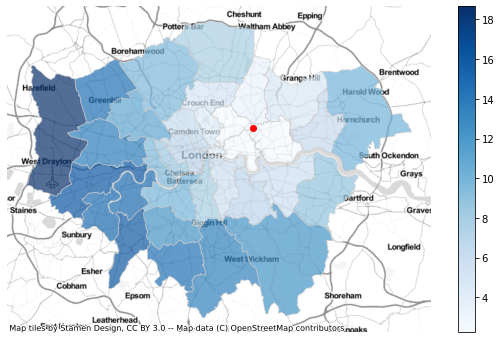

In [162]:
fig, ax = plt.subplots(1, figsize=(10, 6))
mdists.plot(column='Distance', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7, legend=True)
geo_locs.plot(ax=ax, color='red', label="test")
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

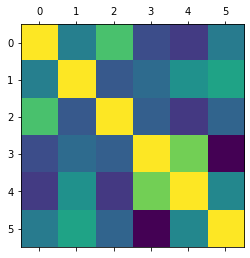

In [151]:
plt.matshow(mdists.join(slopes).corr())

In [163]:
mdists.join(slopes).corr()

,HECTARES,NONLD_AREA,Distance,before,after,diff
HECTARES,1.000000,0.032552,0.509195,-0.304526,-0.410637,0.002356
NONLD_AREA,0.032552,1.000000,-0.228227,-0.109560,0.155395,0.284554
Distance,0.509195,-0.228227,1.000000,-0.189386,-0.423614,-0.155568
before,-0.304526,-0.109560,-0.189386,1.000000,0.638884,-0.704873
after,-0.410637,0.155395,-0.423614,0.638884,1.000000,0.085888
diff,0.002356,0.284554,-0.155568,-0.704873,0.085888,1.000000


In [168]:
profiles = pd.read_csv('london-borough-profiles.csv', encoding='ISO-8859-2')

In [251]:
profiles.set_index('Area_name').loc['Newham']

Code                                                            E09000025
Inner/_Outer_London                                          Inner London
GLA_Population_Estimate_2017                                       342900
GLA_Household_Estimate_2017                                        119172
Inland_Area_(Hectares)                                              3,620
                                                                 ...     
Political_control_in_council                                          Lab
Proportion_of_seats_won_by_Conservatives_in_2014_election               0
Proportion_of_seats_won_by_Labour_in_2014_election                    100
Proportion_of_seats_won_by_Lib_Dems_in_2014_election                    0
Turnout_at_2014_local_elections                                      40.5
Name: Newham, Length: 83, dtype: object

In [176]:
profiles.set_index('Area_name').join(slopes).corr().loc['diff']

GLA_Population_Estimate_2017                          0.053142
Average_Age,_2017                                    -0.520288
Proportion_of_population_aged_0-15,_2015              0.364951
Proportion_of_population_of_working-age,_2015         0.030327
Proportion_of_population_aged_65_and_over,_2015      -0.369532
New_migrant_(NINo)_rates,_(2015/16)                   0.004890
Employment_rate_(%)_(2015)                            0.201356
%_of_employment_that_is_in_public_sector_(2014)       0.421195
Jobs_Density,_2015                                   -0.572503
Number_of_active_businesses,_2015                     0.044611
Two-year_business_survival_rates_(started_in_2013)    0.164120
Number_of_cars,_(2011_Census)                         0.050198
Number_of_cars_per_household,_(2011_Census)          -0.037107
%_children_living_in_out-of-work_households_(2015)    0.346113
Life_satisfaction_score_2011-14_(out_of_10)           0.182076
Worthwhileness_score_2011-14_(out_of_10)             -0

In [177]:
profiles.set_index('Area_name').join(dists).corr().loc['Distance']

GLA_Population_Estimate_2017                          0.035107
Average_Age,_2017                                     0.416243
Proportion_of_population_aged_0-15,_2015              0.142736
Proportion_of_population_of_working-age,_2015        -0.535341
Proportion_of_population_aged_65_and_over,_2015       0.549599
New_migrant_(NINo)_rates,_(2015/16)                  -0.468055
Employment_rate_(%)_(2015)                            0.530636
%_of_employment_that_is_in_public_sector_(2014)      -0.316548
Jobs_Density,_2015                                   -0.201112
Number_of_active_businesses,_2015                    -0.197319
Two-year_business_survival_rates_(started_in_2013)    0.566712
Number_of_cars,_(2011_Census)                         0.570414
Number_of_cars_per_household,_(2011_Census)           0.715940
%_children_living_in_out-of-work_households_(2015)   -0.610379
Life_satisfaction_score_2011-14_(out_of_10)           0.480959
Worthwhileness_score_2011-14_(out_of_10)              0

In [205]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

In [192]:
fa = FactorAnalyzer()

In [201]:
all_things = profiles.set_index('Area_name').join(dists).join(slopes)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = all_things.select_dtypes(include=numerics)
newdf.dropna(inplace=True)

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [260]:
reg_diff = LinearRegression()

reg_diff.fit(newdf.drop(['before', 'after', 'diff'], axis=1), newdf['diff'])

LinearRegression()

In [262]:
reg_diff.coef_

array([ 1.13041087e-07,  3.99150832e-03, -7.99169218e-02, -7.93651567e-02,
       -8.12696225e-02,  4.03166619e-04,  8.68671106e-04, -7.01249423e-04,
       -1.18875340e-03, -6.96348898e-07,  1.88148551e-04, -3.14572851e-07,
        6.14891200e-02,  1.27820961e-03, -1.24351003e-05,  8.46631788e-03,
       -2.41887241e-02,  5.63473545e-04, -2.62652039e-03, -1.31575618e-03])

In [210]:
fa.fit(newdf)

FactorAnalyzer(rotation_kwargs={})

[Text(0, 0, 'GLA_Population_Estimate_2017'),
 Text(0, 0, 'Average_Age,_2017'),
 Text(0, 0, 'Proportion_of_population_aged_0-15,_2015'),
 Text(0, 0, 'Proportion_of_population_of_working-age,_2015'),
 Text(0, 0, 'Proportion_of_population_aged_65_and_over,_2015'),
 Text(0, 0, 'New_migrant_(NINo)_rates,_(2015/16)'),
 Text(0, 0, 'Employment_rate_(%)_(2015)'),
 Text(0, 0, '%_of_employment_that_is_in_public_sector_(2014)'),
 Text(0, 0, 'Jobs_Density,_2015'),
 Text(0, 0, 'Number_of_active_businesses,_2015'),
 Text(0, 0, 'Two-year_business_survival_rates_(started_in_2013)'),
 Text(0, 0, 'Number_of_cars,_(2011_Census)'),
 Text(0, 0, 'Number_of_cars_per_household,_(2011_Census)'),
 Text(0, 0, '%_children_living_in_out-of-work_households_(2015)'),
 Text(0, 0, 'Life_satisfaction_score_2011-14_(out_of_10)'),
 Text(0, 0, 'Worthwhileness_score_2011-14_(out_of_10)'),
 Text(0, 0, 'Happiness_score_2011-14_(out_of_10)'),
 Text(0, 0, 'Anxiety_score_2011-14_(out_of_10)'),
 Text(0, 0, 'People_aged_17+_with_d

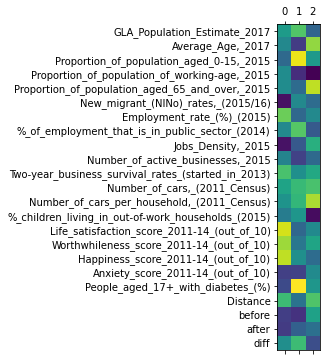

In [229]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.matshow(fa.loadings_)
ax.set_yticks(range(len(newdf.columns)))
ax.set_yticklabels(newdf.columns)

In [230]:
fa.loadings_

array([[ 0.20455621,  0.5562263 , -0.2232727 ],
       [ 0.04645544, -0.51254056,  0.77174599],
       [-0.19199002,  1.02861215,  0.18351304],
       [ 0.08481814, -0.60669884, -0.85876402],
       [ 0.08947563, -0.17723671,  0.89935328],
       [-0.7688784 ,  0.05833292, -0.16997327],
       [ 0.64625198, -0.20421702,  0.0571123 ],
       [ 0.05352107,  0.57521311, -0.31241513],
       [-0.76524879, -0.31826319,  0.36375542],
       [ 0.00955069, -0.47336738, -0.19461221],
       [ 0.52778085,  0.11033632,  0.31096571],
       [ 0.26714087,  0.44722427,  0.5238265 ],
       [ 0.13562825,  0.42780789,  0.83755538],
       [-0.04527542,  0.16056391, -0.79289414],
       [ 0.95685993, -0.2088864 ,  0.06250299],
       [ 0.7979297 , -0.08660636,  0.27354385],
       [ 0.90111879,  0.10659394, -0.17038759],
       [-0.49049069, -0.47220889,  0.06836866],
       [-0.42320568,  1.08358858,  0.1610489 ],
       [ 0.46955788, -0.12250889,  0.54525328],
       [-0.49826405, -0.57469199,  0.250

In [204]:
calculate_kmo(newdf)

(array([0.50195338, 0.40724618, 0.5030258 , 0.51212793, 0.43989836,
        0.62563406, 0.3842402 , 0.506477  , 0.75065326, 0.2760795 ,
        0.46391619, 0.62934622, 0.58640329, 0.55480947, 0.59560716,
        0.54543844, 0.71913712, 0.64377316, 0.39283216, 0.64595233,
        0.55059702, 0.46135628, 0.32142376]),
 0.5233055901117819)

In [206]:
calculate_bartlett_sphericity(newdf)

(1292.1404971909915, 3.018585598585932e-139)

In [208]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
fa.fit(newdf, 25)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

TypeError: fit() got an unexpected keyword argument 'rotation'